# 0. Settings and Utils

In [1]:
# Required Imports
from pymongo import MongoClient
import os
import pandas as pd
from IPython.display import display
from aco.aco_final.MuseumGraphManager import MuseumGraphManager
from aco.aco_final.AlgorithmController import AlgorithmController
import json
from collections import defaultdict
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle

In [2]:
# Dataframe display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option('all')

In [3]:
# DB Connection
CONNECTION_URI = os.getenv("MONGO_CONNECT")
client = MongoClient(CONNECTION_URI, connect=False)
db = client.virtualmuseum
Users = db['users']

# [OPTIONAL] CAUTION!! 
# DELETE VISITS
# Users.update_one({}, {"$set": {"visits": []}})

In [4]:
# Helper Utility Functions
PHEROMONE_CATEGORIES = ["C1", "C2", "C3", "C4"]

def _classify_pheromone(pheromone, rho_min, rho_max):
    l1 = _calculate_limit_for_interval(rho_min, rho_max, 1)
    l2 = _calculate_limit_for_interval(rho_min, rho_max, 2)
    l3 = _calculate_limit_for_interval(rho_min, rho_max, 3)
    l4 = _calculate_limit_for_interval(rho_min, rho_max, 4)

    if pheromone <= l1:
        return PHEROMONE_CATEGORIES[0]
    elif l1 < pheromone <= l2:
        return PHEROMONE_CATEGORIES[1]
    elif l2 < pheromone <= l3:
        return PHEROMONE_CATEGORIES[2]
    elif l3 < pheromone <= l4:
        return PHEROMONE_CATEGORIES[3]
    else:
        raise Exception("Pheromone value is not in any interval")

def _calculate_limit_for_interval(rho_min, rho_max, interval: int):
    """ Interval [1,2,3,4] """
    return rho_min + (interval / 4) * (rho_max - rho_min)

def _get_last_iteration_of_state(current_state, current_state_index, state_list):
    previous_states = state_list[:current_state_index+1]
    iterations_elapsed = 0
    for st in previous_states:
        iterations_elapsed+= st.limit
    return iterations_elapsed

def _get_colors_for_pheromone_categories(available_pheromone_categories, pastel_colors):
    """ Returns list of colors for each pheromone category. The first color corresponds
    to the first category in the provided list, the second color to the second category..."""
    pheromone_category_color_map = dict(zip(PHEROMONE_CATEGORIES, pastel_colors))
    filtered_pastel_colors = []
    for available_ph_cat in available_pheromone_categories:
        required_color = pheromone_category_color_map[available_ph_cat]
        filtered_pastel_colors.append(required_color)
    
    return filtered_pastel_colors

def _get_route_edges(node_list):
    list_size = len(node_list)
    edge_list = []
    for i in range(list_size - 1):
        u = node_list[i]
        v = node_list[i+1]
        edge_list.append((u,v))
    return edge_list    

In [5]:
# Pickling Functions

# Load intermediate states if needed
def load_saved_state_pickles(state_pickles_dir):
    
    def custom_sort(element):
        no_extension = element.split('.')[0]
        return int(no_extension.split('_')[-1])
    
    def sort_list(input_list):
        return sorted(input_list, key=custom_sort)
        
    state_pickles = [f for f in listdir(state_pickles_dir) if isfile(join(state_pickles_dir, f)) and 'pickle' in str(f)]
    if len(state_pickles) == 0:
        print("ERROR: no saved state pickles found")
    
    sorted_state_pickles = sort_list(state_pickles)
    algorithm_states = []
    for sp in sorted_state_pickles:
        full_sp_path = f"{state_pickles_dir}/{sp}"
        state_instance = pickle.load(open(full_sp_path, 'rb'))
        algorithm_states.append(state_instance)
        print(f"Loaded state: {sp}")   
    
    return algorithm_states

def save_algorithm_states_to_pickles(controller, workdir):
    for n, algo_state in enumerate(controller.algorithm_states):
        intermediate_state_name = f"intermediate_state_{limit}iters_{n+1}"
        path_to_pkl = f"{workdir}/{intermediate_state_name}.pickle"
        pickle.dump(algo_state, open(path_to_pkl, 'wb'))
        print(f"Saved state: {intermediate_state_name}")


def save_algorithm_controller_to_pickle(controller, workdir, pickle_name):
    os.makedirs(workdir, exist_ok = True) 
    path_to_pkl = f"{workdir}/{pickle_name}.pickle"
    pickle.dump(controller, open(path_to_pkl, 'wb'))
    print(f"Saved controller: {pickle_name}")

def load_saved_algorithm_controller(workdir, saved_controller_pickle_name):
    full_path_pickle_controller = f"{workdir}/{saved_controller_pickle_name}.pickle"
    algorithm_controller = pickle.load(open(full_path_pickle_controller, 'rb'))
    return algorithm_controller

In [6]:
# Main Utility Functions

def get_dataframe_pheromone_categorisations_of_state(state):
    """ Categorises Pheromones into their corresponding Interval (I1, I2, I3, I4)
    for each saved state.
    The returned dataframe represents the pheromone distribution by each interval; 
    """
    # states = algorithm_controller.algorithm_states  # algorithm_controller.graph
    # for idx, state in enumerate(states):
    graph = state.graph
    rho_max = state.current_upper_bound
    rho_min = state.current_lower_bound
    data1 = {'Pheromone': [], 'Category': []}
    # data2 = {ph_cat: [0] for ph_cat in PHEROMONE_CATEGORIES}
    for edge in graph.edges():
        u, v = edge
        ph = graph[u][v]["pheromone"]
        ph_interval = _classify_pheromone(ph, rho_min, rho_max)
        data1['Pheromone'].append(ph)
        data1['Category'].append(ph_interval)

        # current_sum_in_interval = data2[ph_interval][0]
        # data2[ph_interval] = [current_sum_in_interval + 1]
    df1 = pd.DataFrame(data1)
    # df2 = pd.DataFrame.from_dict(data2)
    return df1

def get_dataframe_pheromone_distribution_across_states(states):
    df = pd.DataFrame()
    for idx, st in enumerate(states):
        graph = st.graph
        total_iterations = _get_last_iteration_of_state(st, idx, states)
        for edge in graph.edges():
            d = {"Pheromone": [], "Iteration": []}
            u, v = edge
            ph = graph[u][v]["pheromone"]
            d['Pheromone'].append(ph)
            d['Iteration'].append(total_iterations)
            df = pd.concat([df, pd.DataFrame(d)], ignore_index=True)
    return df

def train_traditional_mmas_model(algorithm_controller, total_iterations=50, save_state_every_x_iterations=10):
    if total_iterations % save_state_every_x_iterations:
        print("ERROR. Specify a checkpoint value that is multiple of the total number of iterations to compute")

    total_states_to_save = int(total_iterations/save_state_every_x_iterations)
    for i in range(total_states_to_save):
        if i == 0:
            algorithm_controller.compute_initial_iterations(limit=save_state_every_x_iterations)
        else:
            algorithm_controller.compute_next_iterations(limit=save_state_every_x_iterations)
    return algorithm_controller

def train_iml_mmas_model(algorithm_controller, routes_list, starting_iterations=15, 
                         iterations_after_every_feedback=5, manual_pheromone_multiplier=100000000):
    
    algorithm_controller.compute_initial_iterations(limit=starting_iterations)
    
    for route_idx, route in enumerate(routes_list):
        nodes_in_route = route["route"]
        route_repetitions = route["repetitions"]
        route_name = route["name"]
        current_repetitions = 0
        route_edges = _get_route_edges(nodes_in_route)
        
        print("\n")
        print(f"Doing Route: {route_name}")
        print("\n")
        print("\n")
        
        while current_repetitions < route_repetitions:
            
            print("\n")
            print(f"Repeating Route {current_repetitions +1}")
            print("\n")
            
            for idx, edge in enumerate(route_edges):
                if idx == 0 and route_idx != 0:
                    print("Next  iters with starting itertions limit")
                    algorithm_controller.compute_next_iterations(limit=starting_iterations)
                algorithm_controller.manual_pheromone_update(edge, multiplier=manual_pheromone_multiplier)
                algorithm_controller.compute_next_iterations(limit=iterations_after_every_feedback)
            current_repetitions +=1

    # Save controller as pickle
    save_algorithm_controller_to_pickle(algorithm_controller, "mmas_iml_pickles", route_name)
            
    return algorithm_controller

In [7]:
# Main Graph Plotting Functions

def plot_pie_chart_of_pheromone_distribution_of_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml"):
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)
    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states)

    # plotting data on chart 
    result_df = df.groupby('Category')['Pheromone'].count().reset_index(name='Count')

    # define Seaborn color palette to use (specific to each category)
    pastels = sns.color_palette('pastel')[0:3] + [sns.color_palette('pastel')[7]]
    ordered_pastels= _get_colors_for_pheromone_categories(result_df['Category'], pastels)
    
    plt.pie(result_df['Count'], labels=result_df['Category'],
            wedgeprops={'linewidth': 1, 'linestyle': 'solid', "edgecolor":"k"},
            autopct='%.0f%%', colors=ordered_pastels)
    
    plt.title(f'Pheromone Distribution After {total_iterations} Iterations')
    
    # Save plot if specified
    if save_plot:
        name = f"pheromone_dist_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_ecdf_per_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml"):
    
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)
    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states) 
    ecdf = sns.ecdfplot(data=df,x='Pheromone')
    ecdf.set(xscale="log")

    # Show Rho_min and Rho_max
    rho_max = state_to_analyse.current_upper_bound
    rho_min = state_to_analyse.current_lower_bound
    lineprops = { "ymin": 0, "ymax" : 1, "color": "black",
                 "linewidth": 0.5, "linestyle" : "dashed"}
    textprops = {"fontsize": 11, "fontstyle": "oblique", 
                 "color" : "green", "va" : "center"}
    ecdf.axvline(x = rho_min, **lineprops)
    ecdf.axvline(x = rho_max, **lineprops)
    ecdf.text(rho_min, 0.5, r'$\tau_{min}$', **textprops)
    ecdf.text(0.92*rho_max, 0.5, r'$\tau_{max}$', **textprops)

    ecdf.set(title=f"Pheromone ECDF After {total_iterations} Iterations")
    

    # Save plot if specified
    if save_plot:
        name = f"pheromone_ecdf_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_histplot_of_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml"):
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)
    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states) 
    sns.set_palette("pastel", 2)
    hist = sns.histplot(df['Pheromone'].to_numpy(), kde=True)
    hist.set(xscale="log")
    hist.lines[0].set_color('crimson')

    # Show Rho_min and Rho_max
    rho_max = state_to_analyse.current_upper_bound
    rho_min = state_to_analyse.current_lower_bound
    print(f"RHO MIN : {rho_min}")
    max_y = hist.get_ylim()[1]
    lineprops = { "ymin": 0, "ymax" : max_y, "color": "black",
                 "linewidth": 0.5, "linestyle" : "dashed"}
    textprops = {"fontsize": 11, "fontstyle": "oblique", 
                 "color" : "green", "va" : "center"}
    hist.axvline(x = rho_min, **lineprops)
    hist.axvline(x = rho_max, **lineprops)
    hist.text(rho_min, max_y/2, r'$\tau_{min}$', **textprops)
    hist.text(0.92*rho_max, max_y/2, r'$\tau_{max}$', **textprops)

    hist.set(title=f"Pheromone Histogram After {total_iterations} Iterations")
    

    # Save plot if specified
    if save_plot:
        name = f"pheromone_histplot_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_histplot_comparing_states(all_states):
    df = get_dataframe_pheromone_distribution_across_states(all_states)

In [8]:
# Load rooms json
with open('resources/space.json', 'r') as f:
    rooms_json = json.load(f)

# 1. MMAS Without Human Intervention

In [96]:
# Load MMAS MODEL

params = {
    'raw_museum_floorplan': rooms_json,
    'alpha': 1, # pheromone control parameter (higher value means less importance to pheromone)
    'beta': 5, # weight control parameter (higher value means less importance to weight)
    'rho': 0.05, # 0.02
    'pts': True,
    'pts_factor': 1,
    'num_ants': 5, #len(graph.nodes()),
    'start_node': 'D1-1',
    'start_room': 1
}
controller = AlgorithmController(**params)

### Train Model

In [97]:
total_iterations = 300
save_state_every_x_iterations = 60
trained_controller = train_traditional_mmas_model(controller, total_iterations=total_iterations, save_state_every_x_iterations=save_state_every_x_iterations)

Starting mmas algorithm with 60 initial iterations.
Iteration:  0
Iteration:  20
Iteration:  40
Finished computing the initial 60 iterations
Continuing mmas algorithm execution with 60 more iterations.
Iteration:  60
Iteration:  80
Iteration:  100
Done 60 iterations. Waiting for more feedback
Continuing mmas algorithm execution with 60 more iterations.
Iteration:  120
Iteration:  140
Iteration:  160
Done 60 iterations. Waiting for more feedback
Continuing mmas algorithm execution with 60 more iterations.
Iteration:  180
Iteration:  200
Iteration:  220
Done 60 iterations. Waiting for more feedback
Continuing mmas algorithm execution with 60 more iterations.
Iteration:  240
Iteration:  260
Iteration:  280
Done 60 iterations. Waiting for more feedback


### Analyse Pheromones

#### A. Pheromone Distribution Pie Chart (Progressive Analysis)

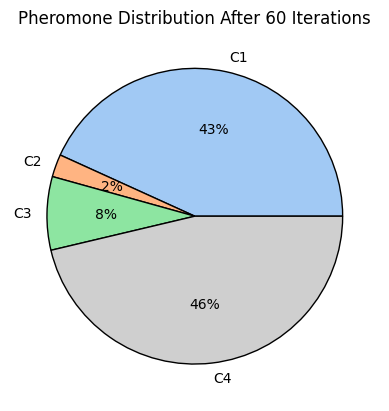

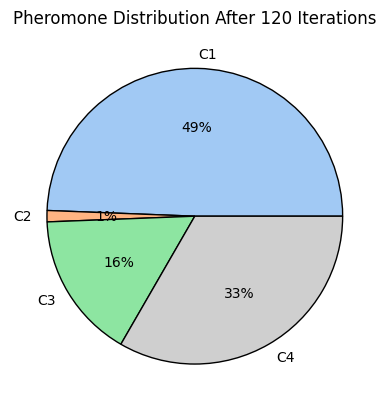

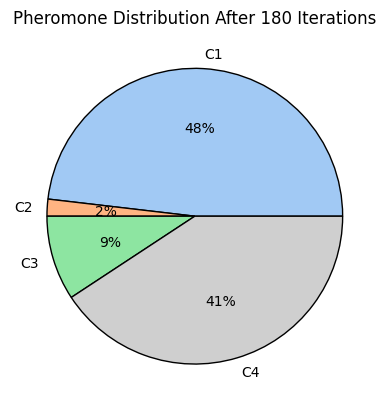

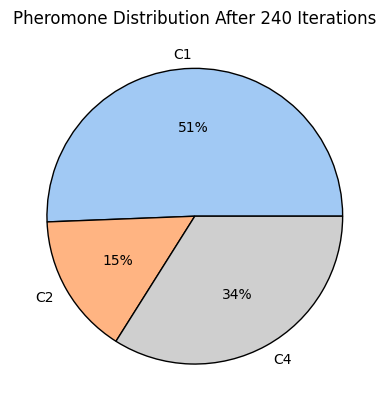

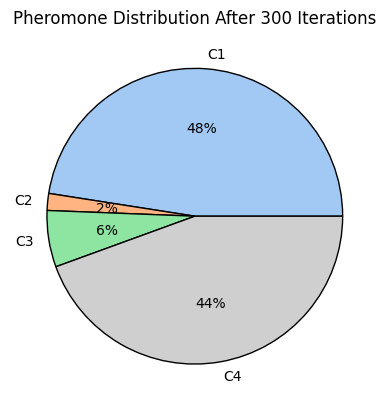

In [68]:
# colors = {"C1": "#a1c9f4", "C2": "#ffb482", "C3": "#8de5a1", "C4": "ff9f9b"}
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pie_chart_of_pheromone_distribution_of_state(state, idx, all_states, save_plot=True, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml")

#### B. Pheromone CDF (Progressive Analysis)

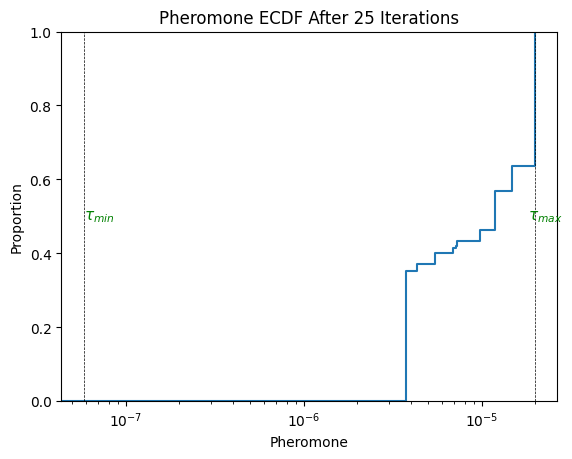

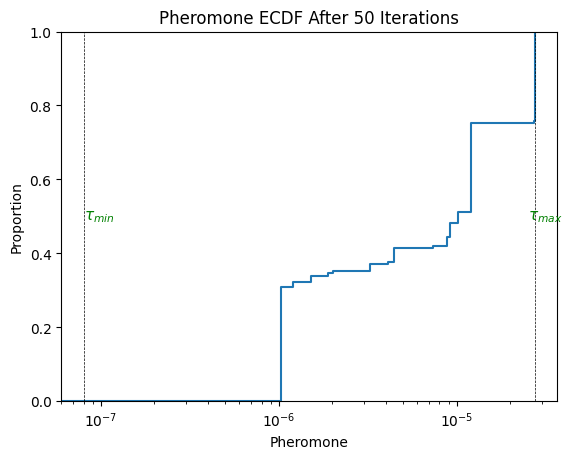

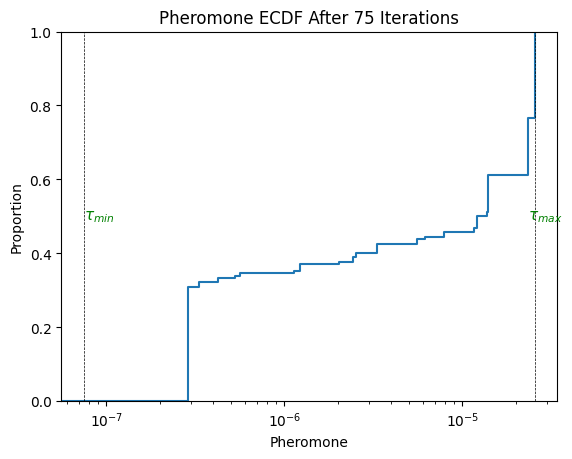

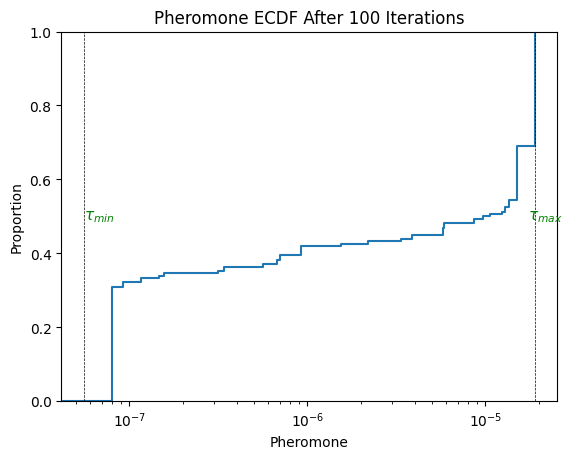

In [53]:
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pheromone_ecdf_per_state(state, idx, all_states, save_plot=True,
                                  saved_plots_dir="evaluation_figures/mmas_no_iml")

#### C. Pheromone Histogram (Progressive Analysis)

RHO MIN : 5.80229147347614e-08


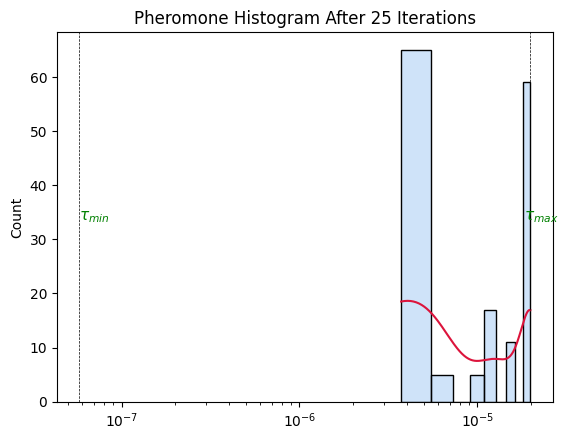

RHO MIN : 8.027439135051576e-08


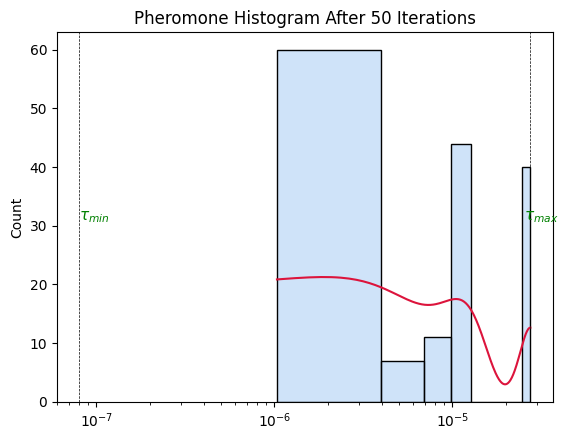

RHO MIN : 7.471047022517858e-08


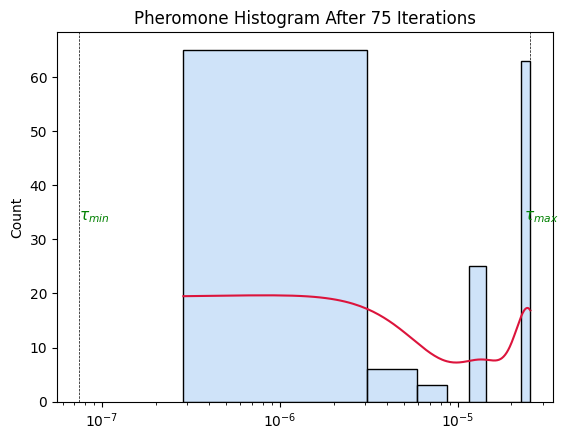

RHO MIN : 5.541251887829239e-08


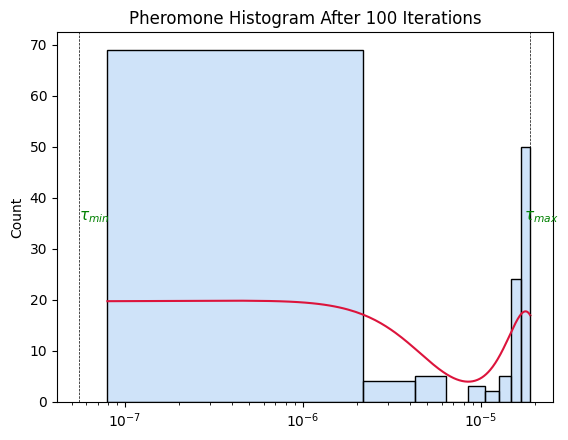

In [54]:
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pheromone_histplot_of_state(state, idx, all_states, save_plot=True,
                                  saved_plots_dir="evaluation_figures/mmas_no_iml")

#### D. Pheromone Histplot, ECDF & ViolinPlot (Comparative Analysis)

In [56]:
df_all_states = get_dataframe_pheromone_distribution_across_states(all_states)

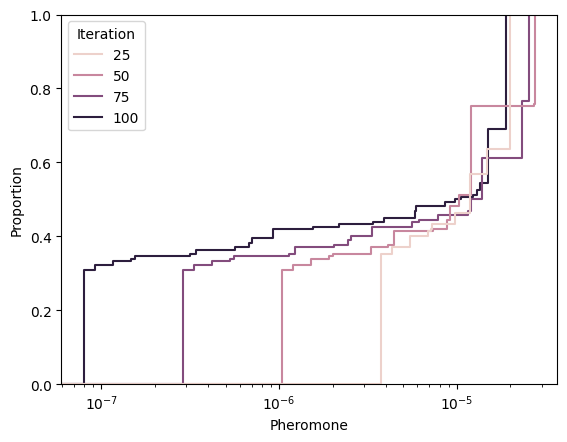

In [57]:
comp_ecdf = sns.ecdfplot(data=df_all_states,x='Pheromone', hue="Iteration")
comp_ecdf.set(xscale="log")
plt.show()

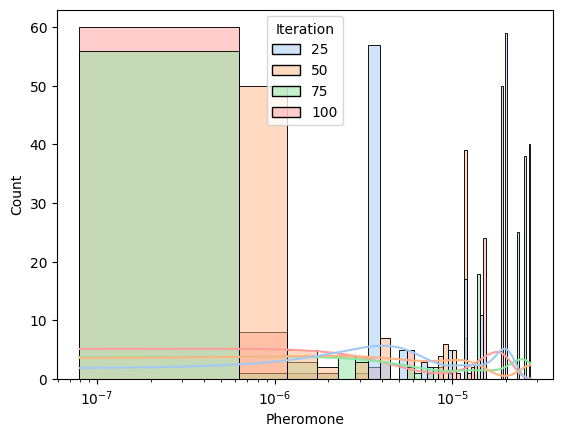

In [58]:
comp_hst = sns.histplot(data=df_all_states, x='Pheromone', hue='Iteration', palette="pastel", kde=True, bins=50)
comp_hst.set(xscale="log")
plt.show()

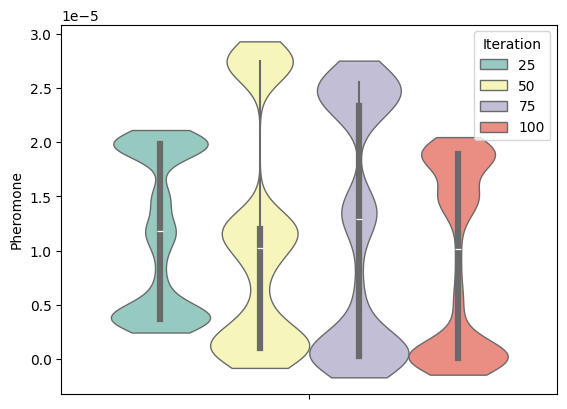

In [63]:
# https://seaborn.pydata.org/examples/wide_form_violinplot.html
comp_vp = sns.violinplot(data=df_all_states, hue='Iteration', y='Pheromone', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")
# comp_vp.set(yscale="log")

# 2. MMAS iML

In [27]:
# Load MMAS MODEL

params = {
    'raw_museum_floorplan': rooms_json,
    'alpha': 1, # pheromone control parameter (higher value means less importance to pheromone)
    'beta': 5, # weight control parameter (higher value means less importance to weight)
    'rho': 0.02, # 0.02
    'pts': True,
    'pts_factor': 1,
    'num_ants': 1, #len(graph.nodes()),
    'start_node': 'D1-1',
    'start_room': 1
}
controller = AlgorithmController(**params)
controller.num_ants = len(controller.graph.nodes())

In [29]:
# #### Setting different visits based on visitor profiles (based on Falk) ###
# ###########################################################################

# EXPERIENCE SEEKER
experience_seeker_route = ["D1-1", "D1-5", "The Cardinal", "D3-5","Self-portrait", "D3-4", "The Immaculate Conception", "D2-4", "Jacob's Dream",
                           "D2-11", "The Crucifixion", "D10-11", "The 3rd of May 1808 in Madrid", "D1-10", 
                           "The Garden of Earthly Delights", "D1-13", "D13-14", "Guernica", "D7-14", "D6-7", "D1-6", "The Three Graces",
                           "The Nobleman with his Hand on his Chest", "The Annunciation", "Las Meninas", "D1-1"
                          ]
experience_seeker_route_reps = 1
experience_seeker_route_name = "experience_seeker_route"

#PROFESSIONAL/HOBBYIST
professional_hobbyist_route = ["D1-1", "Las Meninas", "D1-8", "D7-8", "The Surrender of Breda", "D7-14", "Guernica",
                               "D14-15", "Gaspar de Guzmán, Count-Duke of Olivares, on Horseback", "D14-15", "D13-14",
                               "The Meadow of San Isidro", "Saturn", "D1-13", "The Garden of Earthly Delights", "D1-10", 
                               "The 3rd of May 1808 in Madrid", "D1-10", "D1-1"
                              ]
    
professional_hobbyist_route_reps = 1
professional_hobbyist_route_name = "professional_hobbyist_route"

# EXPLORER
explorer_route = ["D1-1", "Las Meninas", "The Annunciation", "D1-5", "The Cardinal", "D3-5", "Self-portrait",
                  "D3-4", "The Immaculate Conception", "D2-4", "Jacob's Dream", "D2-11", "The Crucifixion", "Christ falls on the Way to Calvary",
                  "D10-11", "Hercules fighting the Nemean Lion", "The 3rd of May 1808 in Madrid", "D10-12", "Guitar and Newspaper", "A la deriva",
                  "D10-12", "D1-10", "The Garden of Earthly Delights", "The Nobleman with his Hand on his Chest", "The Three Graces", "D1-13",
                  "Landscape with Psyche and Jupiter", "Saturn", "The Meadow of San Isidro", "D13-14", "Guernica", "D14-15", 
                  "Gaspar de Guzmán, Count-Duke of Olivares, on Horseback", "D14-15", "D7-14", "The Surrender of Breda", "D7-8",
                  "Judith at the Banquet of Holofernes", "D1-8", "D1-1"
                 ]
                  
explorer_route_reps = 1
explorer_route_name = "explorer_route"

# FACILITATOR
facilitator_route = ["D1-1", "Las Meninas", "The Annunciation", "D1-5", "The Cardinal", "D3-5", "Self-portrait",
                     "D2-3", "D2-11", "The Crucifixion", "Christ falls on the Way to Calvary", "D10-11", "Hercules fighting the Nemean Lion",
                     "The 3rd of May 1808 in Madrid", "D1-10", "The Garden of Earthly Delights", "The Three Graces", "D1-13", "Saturn",
                     "D13-14", "Guernica", "D7-14", "D6-7", "David with the Head of Goliath", "D6-7", "D7-9", "Venus and Adonis", "D7-9",
                     "D7-8", "D1-8", "D1-1"
                    ]  
                     
        
facilitator_route_reps = 1
facilitator_route_name = "facilitator_route"

routes_list = [{"route": experience_seeker_route, "repetitions": experience_seeker_route_reps, "name": experience_seeker_route_name},
               {"route": professional_hobbyist_route, "repetitions": professional_hobbyist_route_reps, "name": professional_hobbyist_route_name},
               {"route": explorer_route, "repetitions": explorer_route_reps, "name": explorer_route_name},
               {"route": facilitator_route, "repetitions": facilitator_route_reps, "name": facilitator_route_name}
              ]

In [30]:
trained_iml_controller = train_iml_mmas_model(controller, routes_list, starting_iterations=10, 
                                              iterations_after_every_feedback=1, manual_pheromone_multiplier=10000000000)

Starting mmas algorithm with 10 initial iterations.
Iteration:  0
Finished computing the initial 10 iterations


Doing Route: experience_seeker_route






Repeating Route 1


Manual pheromone update of edge: ('D1-1', 'D1-5')
Continuing mmas algorithm execution with 1 more iterations.
Done 1 iterations. Waiting for more feedback
Manual pheromone update of edge: ('D1-5', 'The Cardinal')
Continuing mmas algorithm execution with 1 more iterations.
Done 1 iterations. Waiting for more feedback
Manual pheromone update of edge: ('The Cardinal', 'D3-5')
Continuing mmas algorithm execution with 1 more iterations.
Done 1 iterations. Waiting for more feedback
Manual pheromone update of edge: ('D3-5', 'Self-portrait')
Continuing mmas algorithm execution with 1 more iterations.
Done 1 iterations. Waiting for more feedback
Manual pheromone update of edge: ('Self-portrait', 'D3-4')
Continuing mmas algorithm execution with 1 more iterations.
Done 1 iterations. Waiting for more feedback
Manual pheromon

In [31]:
cdf = trained_iml_controller.pheromone_info(use_dataframe=True)
display(cdf)

,nodeA,nodeB,pheromone,weight
0,D1-1,D1-5,0.000024,430.12
1,D1-1,D1-8,0.000024,430.12
2,D1-1,D1-2,0.000021,1003.49
3,D1-1,D1-6,0.000002,1004.04
4,D1-1,D1-13,0.000001,1353.29
5,D1-1,D1-10,0.000003,1491.11
6,D1-1,The Annunciation,0.000012,580.20
7,D1-1,Las Meninas,0.000020,618.46
8,D1-1,The Nobleman with his Hand on his Chest,0.000001,1235.93
9,D1-1,The Three Graces,0.000001,1167.43


In [32]:
trained_iml_controller.print_best_sol()

28485.090000000004
[('D1-1', 'D1-5'), ('D1-5', 'The Annunciation'), ('The Annunciation', 'D1-8'), ('D1-8', 'Las Meninas'), ('Las Meninas', 'D1-6'), ('D1-6', 'D6-13'), ('D6-13', 'Landscape with Psyche and Jupiter'), ('Landscape with Psyche and Jupiter', 'D13-14'), ('D13-14', 'The Meadow of San Isidro'), ('The Meadow of San Isidro', 'Saturn'), ('Saturn', 'D1-13'), ('D1-13', 'The Three Graces'), ('The Three Graces', 'The Nobleman with his Hand on his Chest'), ('The Nobleman with his Hand on his Chest', 'D1-10'), ('D1-10', 'The 3rd of May 1808 in Madrid'), ('The 3rd of May 1808 in Madrid', 'Hercules fighting the Nemean Lion'), ('Hercules fighting the Nemean Lion', 'D10-11'), ('D10-11', 'Christ falls on the Way to Calvary'), ('Christ falls on the Way to Calvary', 'The Crucifixion'), ('The Crucifixion', 'D10-11'), ('D10-11', 'D11-12'), ('D11-12', 'D2-11'), ('D2-11', "Jacob's Dream"), ("Jacob's Dream", 'D2-4'), ('D2-4', 'The Immaculate Conception'), ('The Immaculate Conception', 'D4-5'), ('D4

In [33]:
final_state = trained_iml_controller.algorithm_states[-1]
final_state.graph.nodes()

NodeView(('D1-1', 'D1-5', 'D1-8', 'D1-2', 'D1-6', 'D1-13', 'D1-10', 'The Annunciation', 'Las Meninas', 'The Nobleman with his Hand on his Chest', 'The Three Graces', 'The Garden of Earthly Delights', 'D2-3', 'D2-4', 'D2-11', "Jacob's Dream", 'D3-5', 'D3-4', 'Self-portrait', 'D4-5', 'The Immaculate Conception', 'The Cardinal', 'D6-13', 'D6-7', 'David with the Head of Goliath', 'D7-14', 'D7-8', 'D7-9', 'The Surrender of Breda', 'Judith at the Banquet of Holofernes', 'Venus and Adonis', 'D10-11', 'D10-12', 'The 3rd of May 1808 in Madrid', 'Hercules fighting the Nemean Lion', 'D11-12', 'The Crucifixion', 'Christ falls on the Way to Calvary', 'Guitar and Newspaper', 'A la deriva', 'D13-14', 'Saturn', 'The Meadow of San Isidro', 'Landscape with Psyche and Jupiter', 'D14-15', 'Guernica', 'Gaspar de Guzmán, Count-Duke of Olivares, on Horseback'))

In [35]:
import networkx as nx

def get_max_pheromone_neighbor(graph, current_node):
    neighbors = list(graph.neighbors(current_node))
    
    if not neighbors:
        return None  # No neighbors

    max_pheromone_neighbor = max(neighbors, key=lambda neighbor: graph[current_node][neighbor]['pheromone'])
    
    return max_pheromone_neighbor

def explore_graph_with_max_pheromone(graph, start_node):
    current_node = start_node
    path = [current_node]
    unvisited_nodes = list(graph.nodes())
    unvisited_nodes.remove(current_node)
    
    while len(unvisited_nodes) > 0:
        max_pheromone_neighbor = get_max_pheromone_neighbor(graph, current_node)
        path.append(max_pheromone_neighbor)
        current_node = max_pheromone_neighbor

    return path

In [86]:
# Example usage:
# Assuming 'graph' is your NetworkX graph
import re
PATTERN = re.compile(r'^D\d{1,2}-\d{1,2}$')

def _is_door(node):
    if PATTERN.match(node):
        return True
    else:
        return False

def _get_edge_type_evaluation(u,v):
    if _is_door(u) and _is_door(v):
        return 10
    if (_is_door(u) and not _is_door(v)) or (not _is_door(u) and _is_door(v)):
        return 1
    elif not _is_door(u) and not _is_door(v):
        return 0.1
    else:
        raise Exception(f"Strange: {u} -> {v}")
        
    
def get_inverse_of_pheromone(u,v, edge_attributes):
    "Make dijkstra algorithm get edges with greatest pheromone value"
    pheromone = graph.edges[u, v]['pheromone']
    weight = graph.edges[u, v]['weight']
    multiplier = _get_edge_type_evaluation(u,v)
    inv = 1/pheromone
    print(f'inv pher, w: {inv}  - {weight}')
    return (1/pheromone)*multiplier + weight 
    
graph = final_state.graph
start_node = "D1-1"
target = "Jacob's Dream"
target2 = "Christ falls on the Way to Calvary"
current_node = start_node
p1 = nx.dijkstra_path(graph, start_node, target, weight=get_inverse_of_pheromone)
p2 = nx.dijkstra_path(graph, target, target2, weight=get_inverse_of_pheromone)
#result_path = explore_graph_with_max_pheromone(final_state.graph, start_node)
#print(result_path)

inv pher, w: 41832.40740000002  - 430.12
inv pher, w: 41832.40740000002  - 430.12
inv pher, w: 46777.22684659148  - 1003.49
inv pher, w: 609023.6165146247  - 1004.04
inv pher, w: 827487.3188665777  - 1353.29
inv pher, w: 288595.4820792404  - 1491.11
inv pher, w: 80061.62850745762  - 580.2
inv pher, w: 50730.547719859416  - 618.46
inv pher, w: 827487.3188665777  - 1235.93
inv pher, w: 827487.3188665777  - 1167.43
inv pher, w: 827487.3188665777  - 1678.0
inv pher, w: 50730.547719859416  - 618.46
inv pher, w: 827487.3188665777  - 542.31
inv pher, w: 41832.40740000002  - 217.02
inv pher, w: 432274.58348364034  - 841.51
inv pher, w: 46079.331528529765  - 407.85
inv pher, w: 442447.4072609517  - 763.01
inv pher, w: 827487.3188665777  - 1030.74
inv pher, w: 46079.331528529765  - 495.78
inv pher, w: 827487.3188665777  - 811.65
inv pher, w: 46079.331528529765  - 574.0
inv pher, w: 827487.3188665777  - 1138.13
inv pher, w: 80061.62850745762  - 580.2
inv pher, w: 41832.40740000002  - 175.03
inv p

In [85]:
p1

['D1-1', 'D1-2', 'D2-11', "Jacob's Dream"]

In [62]:
p2

["Jacob's Dream",
 'D2-11',
 'The Crucifixion',
 'Christ falls on the Way to Calvary']

In [187]:
# acnew = load_saved_algorithm_controller("mmas_iml_pickles", "experience_seeker_route")

In [ ]:
# Get user with all visits
user_info = Users.find_one({}, {"visits":1, "username": 1, "_id": 0})
all_visits = user_info["visits"]
valid_visits = list(filter(lambda v: (isinstance(v,list) and len(v) > 1), all_visits))
print(f"{len(valid_visits)} visits registered.")

In [ ]:
# Make a list where each element is a dataframe representing each different visit
visits_dfs = []
for visit in valid_visits:
    df = pd.DataFrame.from_dict(visit)
    visits_dfs.append(df)

# Print Info on Visits
for idx, visit_df in enumerate(visits_dfs):
    
    print("**************")
    print(f"Visit {idx+1}")
    print("**************")
    
    display(df.head())
    print("\n")
    
print("-------------------")
print(f"TOTAL VISITS: {len(visits_dfs)}")

In [37]:
# MMAS Model SOLO Training (No Interactive Feedback)
controller.compute_initial_iterations(limit=5)
cdf = controller.pheromone_info(use_dataframe=True)
display(cdf)

Starting mmas algorithm with 5 initial iterations.
Iteration:  0
Finished computing the initial 5 iterations


,nodeA,nodeB,pheromone,weight
0,D1-1,D1-5,0.000023,430.12
1,D1-1,D1-8,0.000010,430.12
2,D1-1,D1-2,0.000007,1003.49
3,D1-1,D1-6,0.000007,1004.04
4,D1-1,D1-13,0.000007,1353.29
5,D1-1,D1-10,0.000007,1491.11
6,D1-1,The Annunciation,0.000007,580.20
7,D1-1,Las Meninas,0.000007,618.46
8,D1-1,The Nobleman with his Hand on his Chest,0.000007,1235.93
9,D1-1,Las tres Gracias,0.000007,1167.43


In [ ]:
controller.manual_pheromone_and_continue_iters(('D1-1', 'The Nobleman with his Hand on his Chest'), multiplier=10000, limit=5)
#controller.compute_next_iterations(limit=15)
cdf = controller.pheromone_info(use_dataframe=True)
# display(cdf)